In [52]:

from itertools import product
from collections import defaultdict as ddict

import graphviz as gv

import numpy as np
from numpy.random import default_rng
from scipy.stats import geom

from matplotlib.figure import Figure
from matplotlib import cm


In [54]:
%matplotlib

Using matplotlib backend: <object object at 0x00000166D33A3460>


In [6]:
rng = default_rng()

In [22]:
# maf
q = 0.5 # a
p = 1-q # A

afs = {'A': p, 'a': q}

In [133]:
def random_from_pop(n=1):
    x = rng.choice(['AA','Aa', 'aa'], size=n, p=[p*p, 2*p*q, q*q])
    return x if n > 1 else x[0]

def cross(P1, P2):
    outs = ddict(int)
    for z1, z2 in product(P1, P2):
        z1, z2 = sorted([z1, z2])
        outs[z1 + z2] += afs[z1] * afs[z2]
    return outs.items()

def generation(P1=None, P2=None):
    if P1 == None: P1 = random_from_pop()
    if P2 == None: P2 = random_from_pop()

    punnett = cross(P1, P2)

    G, P = zip(*punnett)
    nc = geom.rvs(0.5) # TODO extract 'childattenuation'
    children = rng.choice(G, size=nc, p=P)

    return {'Parents': (P1, P2), 'Children': list(children)}

def family(P1=None, P2=None): # TODO parameterize # of generations
    g1 = generation(P1, P2)
    g2 = [generation(c) for c in g1['Children']]
    g3 = [[generation(c) for c in g2i['Children']] for g2i in g2]

    return g1, g2, g3

colors = {
    "AA": "#ff0000",
    "Aa": "#7f00ff",
    "aa": "#003fff"
}

def flatten(llist):
    out = []
    for l in llist:
        out += l
    return out

def visualize(F, fn='Family Tree.gv'):
    g = gv.Digraph('Family', filename=fn)
    g.attr('node', shape='circle', style='filled')
    famattr = {'rank': 'same'}
    fameattr = {'dir': 'none'}#{}

    # Case 0
    atom = F[0]

    des = atom['Children']
    asc = ['0.m'] * len(des)

    X, Y = atom['Parents']
    with g.subgraph(name='0', graph_attr=famattr, edge_attr=fameattr) as c:
        c.node('0', color=colors[X])
        c.node('0.m', shape='point')
        c.node('1', color=colors[Y])
        c.edge('0', '0.m')
        c.edge('0.m', '1')
    

    for i, f in enumerate(F[1:], start=1):
        sets = f
        for _ in range(i-1):
            sets = flatten(sets)

        nasc = []
        for j, atom in enumerate(sets):
            code = f'{i}.{j}'

            des = atom['Children']
            nasc += [code + '.m'] * len(des)

            X, Y = atom['Parents']
            with g.subgraph(name=f'{i}.{j}', graph_attr=famattr, edge_attr=fameattr) as c:
                c.node(code + '.0', color=colors[X])
                c.node(code + '.m', shape='point')
                c.node(code + '.1', color=colors[Y])
                
                g.edge(asc.pop(0), code + '.0')
                c.edge(code + '.0', code + '.m')
                c.edge(code + '.m', code + '.1')
               
        asc = nasc
    
    return g


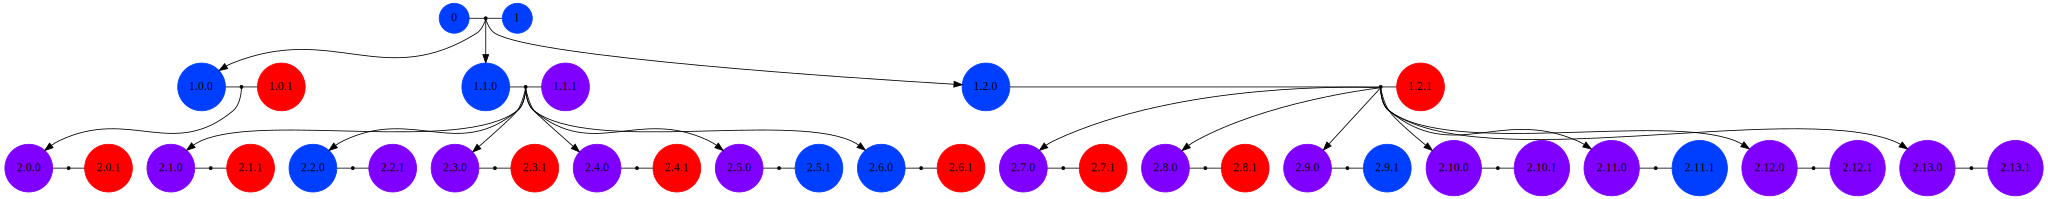

In [136]:
F = family()
G = visualize(F)
G